In [13]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.utils import save_image

import torchbearer
from torchbearer.callbacks import Callback


class AutoEncoderMNIST(Dataset):
    def __init__(self, mnist_dataset):
        super().__init__()
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        character, label = self.mnist_dataset.__getitem__(index)
        return character, label

    def __len__(self):
        return len(self.mnist_dataset)


BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor()])

# Define standard classification mnist dataset

basetrainset = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)

basetestset = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=transform)

# Wrap base classification mnist dataset to return the image as the target

trainset = AutoEncoderMNIST(basetrainset)

testset = AutoEncoderMNIST(basetestset)

traingen = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testgen = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

dropout_value = 0.0

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4)  ,
            nn.ReLU(),
        ) # Input - 28 x 28 x 1 | Output - 26 x 26 x 4 | RF - 3 | Kernel - 3 x 3 x 1 x 4

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8)  ,
            nn.ReLU(),
        ) # Input - 26 x 26 x 4 | Output - 24 x 24 x 8 | RF - 5 | Kernel - 3 x 3 x 4 x 8
        
        # TRANSITION BLOCK 1
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # Input - 24 x 24 x 8 | Output - 12 x 12 x 8 | RF - 10 | Kernel - 2 x 2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16)   ,
            nn.ReLU(),
            
            nn.Dropout(dropout_value)
        ) # Input - 12 x 12 x 8 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 8 x 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 10 x 10 x 16 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 16 x 16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16)   ,
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 8 x 8 x 16 | Output - 8 x 8 x 16 | RF - 14 | Kernel - 3 x 3 x 16 x 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16)   ,
            nn.ReLU(),
            
        ) # Input - 8 x 8 x 16 | Output - 6 x 6 x 16 | RF - 16 | Kernel - 3 x 3 x 16 x 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10)   ,
            nn.ReLU(),
        ) # Input - 6 x 6 x 16 | Output - 4 x 4 x 10 | RF - 18 | Kernel - 3 x 3 x 16 x 10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        # ) # Input - 6 x 6 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 6 x 6 x 10 x 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=784, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # ) # Input - 1 x 1 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 1 x 1 x 10 x 10
        self.dropout = nn.Dropout(dropout_value)
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        self.fc5 = nn.Linear(10, 20)
        

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        x = self.convblock1(x)
#         print(f"1st {sum(torch.isnan(x))}")
        x = self.convblock2(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.convblock3(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.pool1(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.convblock4(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.convblock5(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.convblock6(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.convblock7(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.convblock8(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = self.gap(x)
#         print(f"1st {torch.isnan(sum(x))}")
        x = self.convblock9(x)
#         print(f"1st {torch.isnan(sum(x))}")        
        x = x.view(-1, 784)
#         print(f"1st {torch.isnan(sum(x))}")        
        y = torch.nn.functional.one_hot(y, num_classes = 10) # One hot encoding of the label
        y = y.type(torch.FloatTensor)
        y = self.fc5(y)
        y = self.fc3(y)
        y = self.fc4(y)
        x = torch.add(x.view(-1, 784), y)
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def bce_loss(y_pred, y_true):
    BCE = F.binary_cross_entropy(y_pred, y_true.view(-1, 784), size_average=False)
    return BCE


class AddKLDLoss(Callback):
    def on_criterion(self, state):
        super().on_criterion(state)
        KLD = self.KLD_Loss(state['mu'], state['logvar'])
        state[torchbearer.LOSS] = state[torchbearer.LOSS] + KLD

    def KLD_Loss(self, mu, logvar):
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return KLD


class SaveReconstruction(Callback):
    def __init__(self, num_images=8, folder='results/'):
        super().__init__()
        self.num_images = num_images
        self.folder = folder

    def on_step_validation(self, state):
        super().on_step_validation(state)
        if state[torchbearer.BATCH] == 0:
            data = state[torchbearer.X]
            recon_batch = state[torchbearer.Y_PRED]
            comparison = torch.cat([data[:self.num_images],
                                    recon_batch.view(128, 1, 28, 28)[:self.num_images]])
            save_image(comparison.cpu(),
                       str(self.folder) + 'reconstruction_' + str(state[torchbearer.EPOCH]) + '.png', nrow=self.num_images)


model = VAE()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
loss = bce_loss


In [3]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [9]:
def train(model, device, traingen, optimizer, epoch, train_losses):
    model.train()
    pbar = tqdm(traingen)
    for batch_idx, (images, _) in enumerate(pbar):
        x = images
        x = x.to(device)
        y = _
        y = y.to(device)
        model = model.to(device)
        output_1, mu_1, logvar_1 = model(x, y)
        output_1 = torch.nan_to_num(output_1)
        loss = loss_function(output_1, x, mu_1, logvar_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'Loss={loss.item()} epoch={epoch}')
        train_losses.append(loss.item())
    

In [5]:
def test(model, device, testgen, optimizer, epoch, test_losses):
    model.eval()
    pbar = tqdm(testgen)
    test_loss = 0
    additional_train_loader_dataset = 10000
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(pbar):
            x = images
            x = x.to(device)
            y = _
            y = y.to(device)
            model = model.to(device)
            output_1, mu_1, logvar_1 = model(x, y)
            output_1 = torch.nan_to_num(output_1)
            loss = loss_function(output_1, x, mu_1, logvar_1)
            pbar.set_description(desc= f'Loss={loss.item()} epoch={epoch}')
        test_loss = loss.item() / additional_train_loader_dataset
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}\n'.format(test_loss))
    

In [6]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)
model = VAE()
model.to(device)

cpu


VAE(
  (convblock1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (convblock6): Sequential(
    (0): Conv2d(16,

In [7]:
model = VAE()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.SGD(model.parameters(), lr=0.1,  momentum=0.9)
model = model.to(device)
test_losses = []
train_losses = []

In [12]:
from tqdm import tqdm
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    train(model, device, traingen, optimizer, epoch, train_losses)
    test(model, device, testgen, optimizer, epoch, test_losses)

Epoch: 0


Loss=2259.494873046875 epoch=0: 100%|██████████| 79/79 [00:00<00:00, 79.82it/s] 



Test set: Avg. loss: 0.2259

Epoch: 1


Loss=2019.2978515625 epoch=1: 100%|██████████| 79/79 [00:01<00:00, 56.32it/s] 



Test set: Avg. loss: 0.2019

Epoch: 2


Loss=2069.737548828125 epoch=2: 100%|██████████| 79/79 [00:01<00:00, 75.51it/s]



Test set: Avg. loss: 0.2070

Epoch: 3


Loss=1719.0982666015625 epoch=3: 100%|██████████| 79/79 [00:01<00:00, 73.13it/s]



Test set: Avg. loss: 0.1719

Epoch: 4


Loss=1667.574462890625 epoch=4: 100%|██████████| 79/79 [00:00<00:00, 80.29it/s] 



Test set: Avg. loss: 0.1668

Epoch: 5


Loss=1595.3385009765625 epoch=5: 100%|██████████| 79/79 [00:01<00:00, 70.29it/s]



Test set: Avg. loss: 0.1595

Epoch: 6


Loss=1987.5616455078125 epoch=6: 100%|██████████| 79/79 [00:01<00:00, 76.41it/s]



Test set: Avg. loss: 0.1988

Epoch: 7


Loss=1999.873291015625 epoch=7: 100%|██████████| 79/79 [00:01<00:00, 72.23it/s]



Test set: Avg. loss: 0.2000

Epoch: 8


Loss=1658.4715576171875 epoch=8: 100%|██████████| 79/79 [00:01<00:00, 70.12it/s]



Test set: Avg. loss: 0.1658

Epoch: 9


Loss=1734.46337890625 epoch=9: 100%|██████████| 79/79 [00:01<00:00, 73.07it/s]


Test set: Avg. loss: 0.1734



In [28]:
pbar = tqdm(testgen)
for batch_idx, (images, _) in enumerate(pbar):
    x = images
    x = x.to(device)
    y = _
    y = y.to(device)
    model = model.to(device)
    output_1, mu_1, logvar_1 = model(x, y)
    break

  0%|          | 0/79 [00:00<?, ?it/s]


In [29]:
import matplotlib.pyplot as plt
test = output_1.reshape(-1,1,28,28)
# plt.imshow(test[0].cpu().detach().numpy().squeeze(), cmap='gray_r')

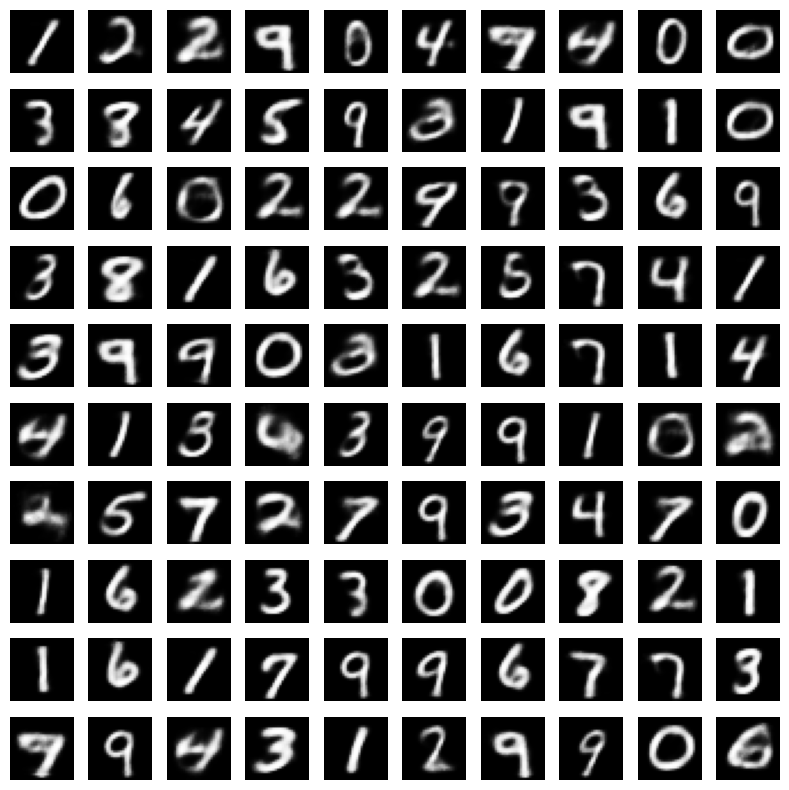

In [30]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img = test[sample_idx].detach().numpy().squeeze()
    figure.add_subplot(rows, cols, i)
#     plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
figure.tight_layout()
plt.show()

  0%|          | 0/79 [00:00<?, ?it/s]


In [31]:
pbar = tqdm(testgen)
for batch_idx, (images, _) in enumerate(pbar):
    x = images
    x = x.to(device)
#     print(x.shape)
    y = torch.randint(0, 9, (128, 1)).squeeze()
    y = y.to(device)
#     print(y.shape)
    model = model.to(device)
    output_1, mu_1, logvar_1 = model(x, y)
    break

  0%|          | 0/79 [00:00<?, ?it/s]


In [32]:
test_new = output_1.reshape(-1,1,28,28)

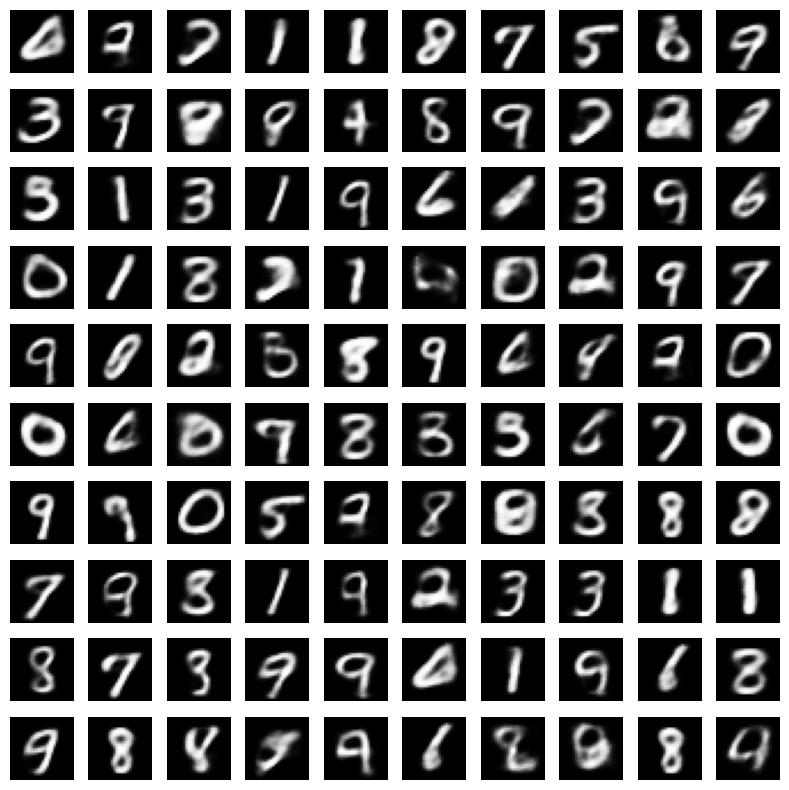

In [33]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_new), size=(1,)).item()
    img = test_new[sample_idx].detach().numpy().squeeze()
    figure.add_subplot(rows, cols, i)
#     plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
figure.tight_layout()
plt.show()